In [31]:
import webrtcvad
import numpy as np
from scipy.io import wavfile
import librosa as rs
import matplotlib.pyplot as plt
import random
import string
import copy
from audiotsm import wsola
from audiotsm.io.wav import WavReader, WavWriter
import subprocess
from scipy.signal import resample, lfilter

In [12]:
# voice modification methods
def randomname(n = 10):
  return ''.join(random.choices(string.ascii_letters + string.digits, k=n))

def resampling(x, coef = 1.):
  fn = "resampling" + "/" + randomname(20) + ".wav"

  wavfile.write(fn, 16000, x.astype(np.int16))
  with WavReader(fn) as fr:
    with WavWriter(fn + "_resample.wav", fr.channels, fr.samplerate) as fw:
      tsm = wsola(channels = fr.channels, speed = coef, frame_length = 256, synthesis_hop = int(fr.samplerate / 70.0))
      tsm.run(fr, fw)

  _, y = wavfile.read(fn + "_resample.wav")
  y = resample(y, len(x)).astype(x.dtype)

  return y

def vtln(x, alpha = 0.):
  # STFT
  mag_x, phase_x = rs.magphase(rs.core.stft(x))
  mag_x, phase_x = np.log(mag_x).T, phase_x.T

  # Frequency
  freq = np.linspace(0, np.pi, mag_x.shape[-1]) #+ 1e-30
  freq_warped = freq + 2.0 * np.arctan(alpha * np.sin(freq) / (1 - alpha * np.cos(freq)))

  # Warping
  mag_x_warped = np.zeros(mag_x.shape, dtype = mag_x.dtype)
  for t in range(mag_x.shape[0]):
    mag_x_warped[t, :] = np.interp(freq, freq_warped, mag_x[t, :])

  # ISTFT
  y = np.real(rs.core.istft(np.exp(mag_x_warped).T * phase_x.T)).astype(x.dtype)

  if y.shape[0] == x.shape[0]:
    return y
  elif y.shape[0] > x.shape[0]:
    return y[:x.shape[0]]
  else:
    return np.pad(y, (0, x.shape[0] - y.shape[0]))

In [37]:
def anon_method(x, method1_param, method2_param):
    
    y = copy.deepcopy(x)
    
    y = resampling(y, method1_param)
    y = vtln(y, method2_param)
    
    return y

# voice activity detection
def VAD(x, fs = 16000, smoothing = True):
    # set VAD
    vad = webrtcvad.Vad()
    vad.set_mode(3)
    frame_length, shift_length = int(fs * 30.0 * 1e-3), int(fs * 5.0 * 1e-3)

    # framing
    x_frame = rs.util.frame(x, frame_length, shift_length).astype(np.int16).T
    
    # VAD
    result = [vad.is_speech(xf.tobytes("C"), fs) for xf in x_frame]
    
    if smoothing:
        filter_length = 21 # 約0.1秒までは許容
        filt = np.ones(filter_length) / (filter_length - 1.)
        filt[int(filter_length/2)] = 0.

        result = np.clip(np.ceil(np.convolve(result, filt, "full")), 0, 1)[int(filter_length/2):-int(filter_length/2)]

    return list(result)


# time-switching anonymization
def time_switching_hiding_2(x, method, param1_base, param1_tune, param2_base, param2_tune, fs = 16000, allow_vsplit = True):
    """
    Anonymize speech with time-switching parameters.

    Input:
        x: waveform
        method: anonymization function
        param1, param2: anonymization parameter 1, 2
        fs: sampling frequency
        allow_vsplit: If True, allow switching within a voicing segment.
            If False, switch at a silence frame (except x has only one voicing segment.)
    """

    # run VAD
    vad_result = np.asarray(VAD(x, fs), dtype = np.int16)
    vad_result[0], vad_result[-1] = 0, 0
    shift_length = int(x.shape[0] / float(vad_result.shape[0]))

    # run two-type anonimyzation that does not change waveform length
    yp = [method(x, param1_base - param2_tune, param2_base - param2_tune), 
          method(x, param1_base + param1_tune, param2_base + param2_tune)]
    
    print(len(yp[0]), len(yp[1]))
    if (len(yp[0]) != len(x)) or (len(yp[1]) != len(x)):
        raise ValueError("Anonymization function changed waveform length.")

    y = np.zeros(x.shape[0], dtype = x.dtype)

    # find frames that VAD activated
    if allow_vsplit:
        time_activated = [0, int(np.average(np.where(vad_result == 1)[0]))]
        idx = [0, 1]
    else:
        time_activated = np.where(vad_result - np.roll(vad_result, 1) != 0)[0]
        if time_activated is None:
            raise ValueError("Cannot detect voice frames.")

        time_activated = time_activated.reshape(-1, 2)
        if time_activated.shape[0] == 1: # only one voicing segment
            tmp = np.zeros((2, 2), dtype = time_activated.dtype)
            tmp[0, 0], tmp[1, 1] = time_activated[0, 0], time_activated[0, 1]
            tmp[0, 1], tmp[1, 0] = int(np.mean(time_activated[0, :])), int(np.mean(time_activated[0, :]))
            time_activated = tmp
        
        # determine time index
        dur = time_activated[:, 1] - time_activated[:, 0]
        i = min(max(1, np.where(np.cumsum(dur[np.argsort(-dur)]) >= np.sum(dur) / 2.0)[0][0]), len(dur) - 1)
        idx = np.zeros(time_activated.shape[0], dtype = np.int16)
        idx[np.argsort(-dur)[:i]] = 1    

        time_activated = time_activated[:, 0]
        time_activated[0] = 0

    for i, t in zip(idx, time_activated):
        st = t * shift_length 
        y[st:] = yp[i][st:]

    return y

# time-switching anonymization
def time_switching_hiding(x, method, param1, param2, fs = 16000, allow_vsplit = True):
    """
    Anonymize speech with time-switching parameters.

    Input:
        x: waveform
        method: anonymization function
        param1, param2: anonymization parameter 1, 2
        fs: sampling frequency
        allow_vsplit: If True, allow switching within a voicing segment.
            If False, switch at a silence frame (except x has only one voicing segment.)
    """

    # run VAD
    vad_result = np.asarray(VAD(x, fs), dtype = np.int16)
    vad_result[0], vad_result[-1] = 0, 0
    shift_length = int(x.shape[0] / float(vad_result.shape[0]))

    # run two-type anonimyzation that does not change waveform length
    yp = [method(x, param1-param2), method(x, param1 + param2)]
    
    print(len(yp[0]), len(yp[1]))
    if (len(yp[0]) != len(x)) or (len(yp[1]) != len(x)):
        raise ValueError("Anonymization function changed waveform length.")

    y = np.zeros(x.shape[0], dtype = x.dtype)

    # find frames that VAD activated
    if allow_vsplit:
        time_activated = [0, int(np.average(np.where(vad_result == 1)[0]))]
        idx = [0, 1]
    else:
        time_activated = np.where(vad_result - np.roll(vad_result, 1) != 0)[0]
        if time_activated is None:
            raise ValueError("Cannot detect voice frames.")

        time_activated = time_activated.reshape(-1, 2)
        if time_activated.shape[0] == 1: # only one voicing segment
            tmp = np.zeros((2, 2), dtype = time_activated.dtype)
            tmp[0, 0], tmp[1, 1] = time_activated[0, 0], time_activated[0, 1]
            tmp[0, 1], tmp[1, 0] = int(np.mean(time_activated[0, :])), int(np.mean(time_activated[0, :]))
            time_activated = tmp
        
        # determine time index
        dur = time_activated[:, 1] - time_activated[:, 0]
        i = min(max(1, np.where(np.cumsum(dur[np.argsort(-dur)]) >= np.sum(dur) / 2.0)[0][0]), len(dur) - 1)
        idx = np.zeros(time_activated.shape[0], dtype = np.int16)
        idx[np.argsort(-dur)[:i]] = 1    

        time_activated = time_activated[:, 0]
        time_activated[0] = 0

    for i, t in zip(idx, time_activated):
        st = t * shift_length 
        y[st:] = yp[i][st:]

    return y

80441 80441
80441 80441


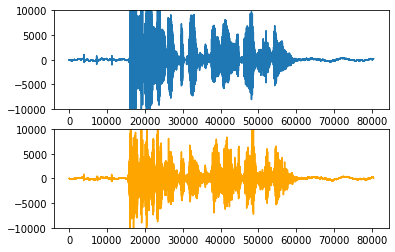

In [45]:
def sugoi_method(x, scale):
    return scale * x

fs, x = wavfile.read("p234_030_mic2.wav")
x = x.astype(np.float32)

# original waveform
plt.subplot(211)
plt.ylim(-10000, 10000)
plt.plot(x)

resample_base=1.0
resample_coef=0.2
vtln_base=0.0
vtln_coef=0.1

# anonymized waveform
plt.subplot(212)
plt.ylim(-10000, 10000)
#wave_vc = Parallel(n_jobs=-1)( [delayed(voice_change)(w, f, **params) for w, f in zip(wave, trial_utt)] )
#y = time_switching_hiding_2(x,anon_method,param1_base=resample_base,param1_tune=resample_coef,param2_base=vtln_base,param2_tune=vtln_coef)
y = time_switching_hiding(x, resampling, 1.0, 0.2) 
y = time_switching_hiding(y, vtln, 0.0, 0.1)
#y = time_switching_hiding(x, sugoi_method, 2.0, 0.2) # 波形の2倍/0.2倍を実行
plt.plot(y, color = "orange")

wavfile.write("gomi_2.wav", 16000, y.astype(np.int16))

In [46]:
fs, x = wavfile.read("gomi_2.wav")
x = x.astype(np.float32)

In [47]:
x

array([-10., -21., -17., ...,   0.,   0.,   0.], dtype=float32)

In [44]:
x

array([-34., -36., -34., ...,   0.,   0.,   0.], dtype=float32)